In [ ]:
import pandas as pd
import numpy as np

# 1. Charger les données
df = pd.read_csv("/content/synthetic_fraud_dataset.csv")  # adapte le chemin si besoin
S
# 2. Supprimer les lignes avec des valeurs manquantes dans la cible
df = df.dropna(subset=["Is_Fraud"])

# 3. Ajouter des features simulées

# a) Transaction_Category (achat, retrait, virement)
np.random.seed(42)  # pour reproductibilité
df["Transaction_Category"] = np.random.choice(["achat", "retrait", "virement"], size=len(df))
df = pd.get_dummies(df, columns=["Transaction_Category"])

# b) Is_Large_Transaction (1 si montant élevé)
df["Is_Large_Transaction"] = (df["Transaction_Amount"] > 0.5).astype(int)

# c) Balance_Change (variation du solde après transaction)
df["Balance_Change"] = df["Transaction_Amount"] * np.random.uniform(-1.5, 1.5, size=len(df))

# d) Is_New_User (nouvel utilisateur ou non)
df["Is_New_User"] = np.random.choice([0, 1], size=len(df), p=[0.7, 0.3])

# e) Amount_vs_Balance (ratio entre le montant et le solde, éviter la division par 0)
df["Amount_vs_Balance"] = df["Transaction_Amount"] / (df["Account_Balance"] + 1e-6)

# 4. Afficher les premières lignes pour vérification
print(df.head())

# 5. Enregistrer le nouveau dataset si besoin
df.to_csv("Bank_Transaction_Fraud_Detection_FE.csv", index=False)


                            Customer_ID        Customer_Name  Gender  Age  \
0  d5f6ec07-d69e-4f47-b9b4-7c58ff17c19e           Osha Tella    Male   60   
1  7c14ad51-781a-4db9-b7bd-67439c175262      Hredhaan Khosla  Female   51   
2  3a73a0e5-d4da-45aa-85f3-528413900a35       Ekani Nazareth    Male   20   
3  7902f4ef-9050-4a79-857d-9c2ea3181940  Yamini Ramachandran  Female   57   
4  3a4bba70-d9a9-4c5f-8b92-1735fd8c19e9         Kritika Rege  Female   43   

         State                City                Bank_Branch Account_Type  \
0       Kerala  Thiruvananthapuram  Thiruvananthapuram Branch      Savings   
1  Maharashtra              Nashik              Nashik Branch     Business   
2        Bihar           Bhagalpur           Bhagalpur Branch      Savings   
3   Tamil Nadu             Chennai             Chennai Branch     Business   
4       Punjab            Amritsar            Amritsar Branch      Savings   

                         Transaction_ID Transaction_Date  ...  \
0  

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 253.9/253.9 MB 4.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 238.4/238.4 kB 19.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 322.4/322.4 MB 3.3 MB/s eta 0:00:00
Évaluation du modèle : Random Forest
--- Évaluation pour RandomForestClassifier ---
Accuracy: 0.9164 ± 0.0011
Precision: 0.9087 ± 0.0014
Recall: 0.9258 ± 0.0011
F1-Score: 0.9172 ± 0.0011
ROC-AUC: 0.9737 ± 0.0004



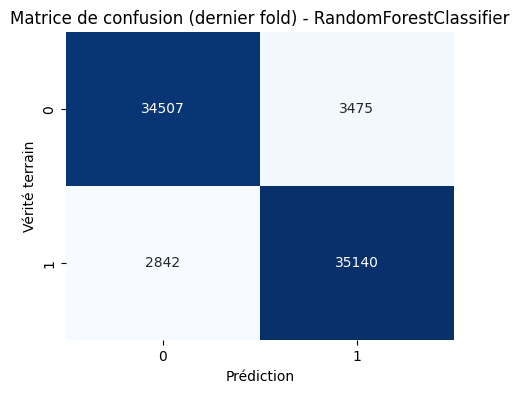

Évaluation du modèle : XGBoost
--- Évaluation pour XGBClassifier ---
Accuracy: 0.7985 ± 0.0046
Precision: 0.9729 ± 0.0019
Recall: 0.6141 ± 0.0084
F1-Score: 0.7529 ± 0.0068
ROC-AUC: 0.8687 ± 0.0032



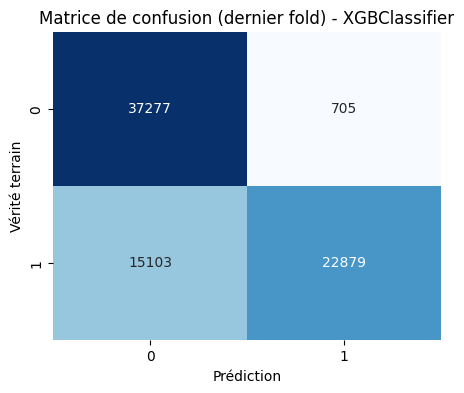

In [ ]:
!pip install imblearn xgboost
import pandas as pd
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# 1. Charger les données
df = pd.read_csv('/content/Bank_Transaction_Fraud_Detection_FE.csv')
df = df.dropna(subset=['Is_Fraud'])

# 2. Séparer X et y
X = df.drop('Is_Fraud', axis=1)
y = df['Is_Fraud']

# 3. Supprimer colonnes non numériques (IDs, UUID, etc.)
non_numeric_cols = X.select_dtypes(exclude=['number']).columns
X = X.drop(columns=non_numeric_cols)

# 4. Normalisation
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# 5. Rééquilibrage avec SMOTE
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_scaled, y)

# 6. Préparer la validation croisée stratifiée
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# 7. Initialiser les modèles (sans use_label_encoder pour éviter warning)
models = {
    "Random Forest": RandomForestClassifier(random_state=42),
    "XGBoost": XGBClassifier(eval_metric='logloss', random_state=42)
}

# 8. Fonction d'évaluation avec cross-validation + matrice de confusion sur dernier fold
def evaluate_model_with_confusion(model, X, y, cv):
    accuracies = []
    precisions = []
    recalls = []
    f1s = []
    roc_aucs = []
    last_cm = None

    for fold_idx, (train_idx, test_idx) in enumerate(cv.split(X, y)):
        X_train, X_test = X[train_idx], X[test_idx]
        y_train, y_test = y[train_idx], y[test_idx]

        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        y_prob = model.predict_proba(X_test)[:, 1]

        accuracies.append(accuracy_score(y_test, y_pred))
        precisions.append(precision_score(y_test, y_pred))
        recalls.append(recall_score(y_test, y_pred))
        f1s.append(f1_score(y_test, y_pred))
        roc_aucs.append(roc_auc_score(y_test, y_prob))

        # Garder la matrice de confusion du dernier fold
        if fold_idx == cv.get_n_splits() - 1:
            last_cm = confusion_matrix(y_test, y_pred)

    print(f"--- Évaluation pour {model.__class__.__name__} ---")
    print(f"Accuracy: {np.mean(accuracies):.4f} ± {np.std(accuracies):.4f}")
    print(f"Precision: {np.mean(precisions):.4f} ± {np.std(precisions):.4f}")
    print(f"Recall: {np.mean(recalls):.4f} ± {np.std(recalls):.4f}")
    print(f"F1-Score: {np.mean(f1s):.4f} ± {np.std(f1s):.4f}")
    print(f"ROC-AUC: {np.mean(roc_aucs):.4f} ± {np.std(roc_aucs):.4f}\n")

    # Afficher la matrice de confusion
    plt.figure(figsize=(5,4))
    sns.heatmap(last_cm, annot=True, fmt='d', cmap='Blues', cbar=False)
    plt.title(f'Matrice de confusion (dernier fold) - {model.__class__.__name__}')
    plt.xlabel('Prédiction')
    plt.ylabel('Vérité terrain')
    plt.show()

# 9. Lancer l'évaluation
for name, model in models.items():
    print(f"Évaluation du modèle : {name}")
    evaluate_model_with_confusion(model, X_resampled, y_resampled, skf)


In [ ]:
import joblib


for name, model in models.items():
    joblib.dump(model,f'{name}.pkl')


In [ ]:

joblib.dump(scaler,"scaler.pkl")

['scaler.pkl']